# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 5,75.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
train_data = pd.read_csv(r"C:\Users\Эрвин\Documents\Machine Learning\2ht\train.csv")

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
train_data.drop('dropoff_datetime', inplace = True, axis = 1)
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'], format = "%Y-%m-%d %H:%M:%S")

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

Text(0.5, 0, 'trip duration')

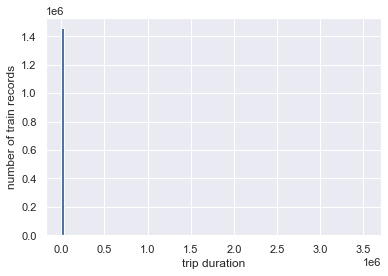

In [6]:
plt.hist(train_data.trip_duration.values, bins = 100)
plt.ylabel('number of train records')
plt.xlabel('trip duration')

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: В выборке имеются выбросы.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: Потому что RMSLE штрафует за заниженные ожидания сильнее, чем за завышенные, а в случае с предсказанием длительности поездки гораздо важнее избежать именно заниженных прогнозов.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: Оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$, поскольку при подстановке в формулу RMSLE модифицированного таргета и предсказание, обучавшимся на логарифме таргета, получится формула RMSE для полученной модели.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

Text(0.5, 0, 'log trip duration')

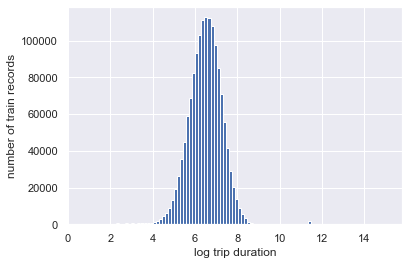

In [7]:
train_data['log_trip_duration'] = np.log1p(train_data['trip_duration'])
train_data.drop('trip_duration', inplace = True, axis = 1)
plt.hist(train_data.log_trip_duration.values, bins = 100)
plt.ylabel('number of train records')
plt.xlabel('log trip duration')

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [8]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.mean(train_data["log_trip_duration"]) * np.ones(train_data.shape[0]), train_data["log_trip_duration"])

0.6332327625405546

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

C:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dayofyear', ylabel='count'>

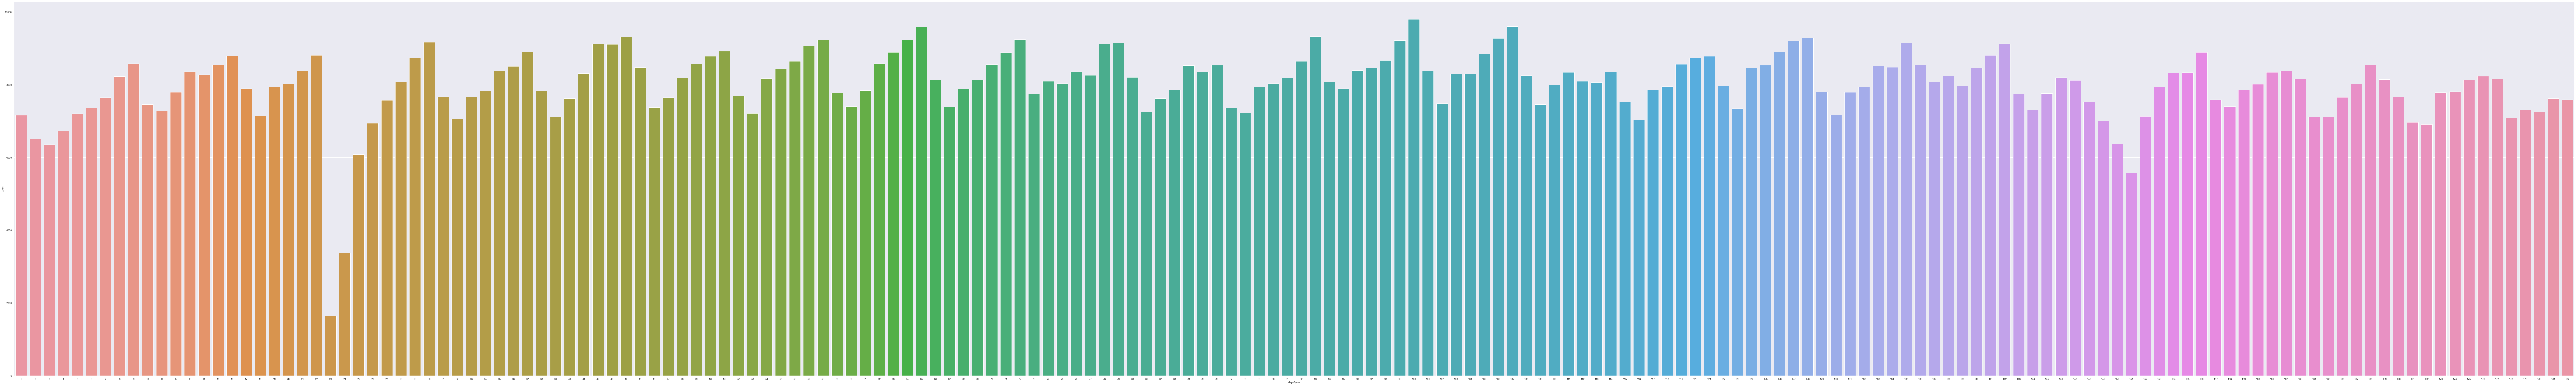

In [9]:
train_data["hour"] = train_data["pickup_datetime"].dt.hour
train_data["dayofweek"] = train_data["pickup_datetime"].dt.dayofweek
train_data["month"] = train_data["pickup_datetime"].dt.month
train_data["dayofyear"] = train_data["pickup_datetime"].dt.dayofyear
plt.rcParams["figure.figsize"] = (200, 30)
sns.countplot(train_data["dayofyear"])

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ**: Из графика можно увидеть, что есть два периода, в котором значения аномально низки: с 23 января по 24 января и 30 мая (перевод из формата дня в году в обычную дату был сделан с помощью данного календаря: https://asd.gsfc.nasa.gov/Craig.Markwardt/doy2016.html)

Первый период может быть объяснён тем, что с 22 по 24 январе 2016 года в США бушевала сильная снежная буря, из-за чего в Нью-Йорке с 23 января по 24 был введён запрет на поездки. Источник: https://en.wikipedia.org/wiki/January_2016_United_States_blizzard

Второй может быть объяснён сбоем в работе компьютера аэропорта имени Джона Кеннеди, из-за чего пришлось проверять пассажиров вручную, что и вызвало задержки. Источник: https://www.theguardian.com/us-news/2016/may/30/jfk-airport-new-york-flight-delays-terminal-7

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

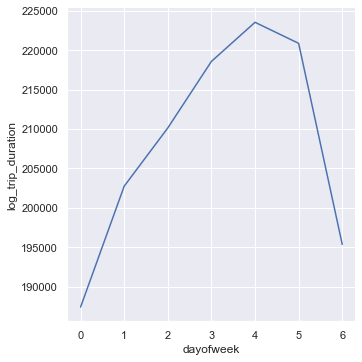

In [10]:
trip_count = pd.DataFrame(train_data.groupby(['dayofweek'])['log_trip_duration'].count())
sns.relplot(data=trip_count, x="dayofweek", y="log_trip_duration", kind="line")

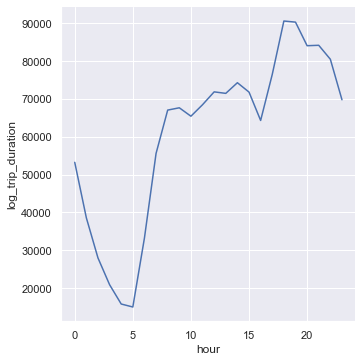

In [11]:
trip_count = pd.DataFrame(train_data.groupby(['hour'])['log_trip_duration'].count())
sns.relplot(data=trip_count, x="hour", y="log_trip_duration", kind="line")

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

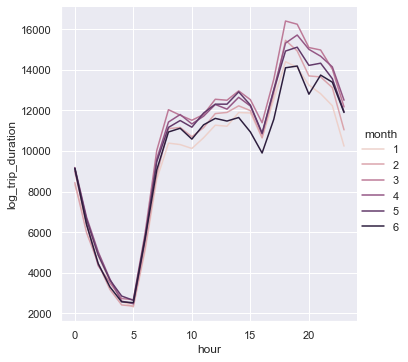

In [12]:
trip_count = pd.DataFrame(train_data.groupby(['month','hour'])['log_trip_duration'].count())
sns.relplot(data=trip_count, x="hour", y="log_trip_duration", hue="month", kind="line")

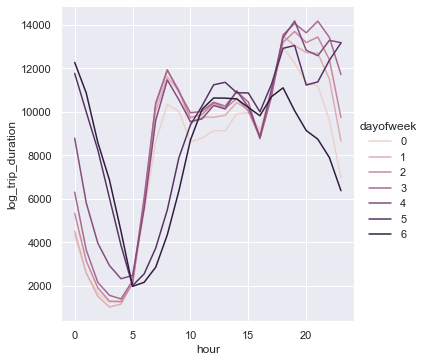

In [13]:
trip_count = pd.DataFrame(train_data.groupby(['dayofweek','hour'])['log_trip_duration'].count())
sns.relplot(data=trip_count, x="hour", y="log_trip_duration", hue="dayofweek", kind="line")

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: На обоих графиках заметен один и тот же тренд: самые низкие показатели наблюдаются в период раннего утра (4-5 часов ночи), но, как только преодолевается рубеж около 5 утра, график начинает стремительно расти (скорее всего потому, что люди пользуются такси для того, чтобы добраться на работу), но замедляет свой рост в районе 9 часов и либо растёт далее медленно, либо на время теряет в показателях. Ситуация остаётся примерно стабильной до 3-4 часов вечера, после чего показатели вновь растут (видимо, люди уходят с работы) и, достигнув пика в районе около 6 часов вечера, вновь начинают снижаться. Причём если ситуация не особо отличается для разных месяцев, то для разных дней недели могут наблюдаться значительные расхождения от тренда. Связано это прежде всего с разделением дней на будние и выходные: графики для будних дней не особо отличаются друг от друга, как и графики выходных дней, в то время как график для буднего дня и выходного будет иметь уже заметные расхождения.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(["log_trip_duration"], axis=1), train_data["log_trip_duration"], test_size=0.3, random_state=10)

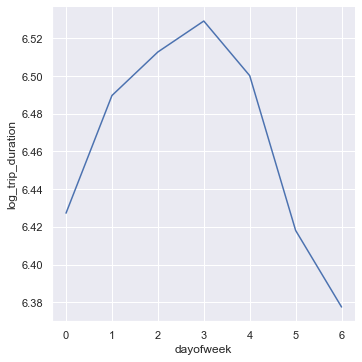

In [15]:
trip_mean = X_train.join(y_train)
trip_mean = pd.DataFrame(trip_mean.groupby(['dayofweek'])['log_trip_duration'].mean())
sns.relplot(data=trip_mean, x="dayofweek", y="log_trip_duration", kind="line")

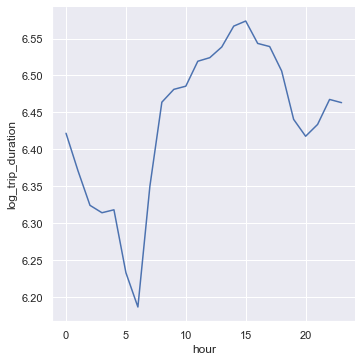

In [16]:
trip_mean = X_train.join(y_train)
trip_mean = pd.DataFrame(trip_mean.groupby(['hour'])['log_trip_duration'].mean())
sns.relplot(data=trip_mean, x="hour", y="log_trip_duration", kind="line")

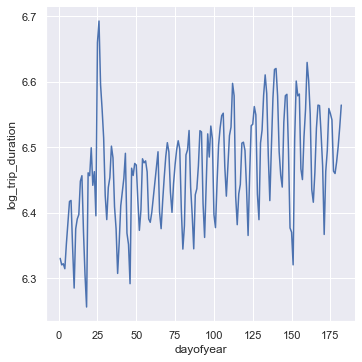

In [17]:
trip_mean = X_train.join(y_train)
trip_mean = pd.DataFrame(trip_mean.groupby(['dayofyear'])['log_trip_duration'].mean())
sns.relplot(data=trip_mean, x="dayofyear", y="log_trip_duration", kind="line")

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ**: Похожи, хотя различия видны невооруженным глазом. Различия эти, скорее всего, были получены из-за "усреднения" таргета. В первый аномальный период длительность поездок резко уходит вверх до абсолютного пика, в то время как во второй период наблюдается резкое падение. Скорее всего, происходит так потому, что если поездки и случались в период снежной бури, то они, скорее всего, занимали огромное количество времени, в то время как из-за сбоя в работе аэропорта меньше людей добирались до этого самого аэропорта и, значит, показатель длительности поездок, соответственно, падает. В принципе, на графике наблюдается тренд, при котором на всём протяжении графика средняя длительность поездок резко меняется с завидной регулярностью.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

**Примечание**: для удобства день недели, месяц, час и номер дня в году были добавлены ранее в самом начале этой части.

In [18]:
train_data["anomaly"] = (train_data["dayofyear"]==23) | (train_data["dayofyear"]==24) | (train_data["dayofyear"]==151)
X_train["anomaly"] = (X_train["dayofyear"]==23) | (X_train["dayofyear"]==24) | (X_train["dayofyear"]==151)
X_test["anomaly"] = (X_test["dayofyear"]==23) | (X_test["dayofyear"]==24) | (X_test["dayofyear"]==151)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ**: Однозначно к категориальному признаку можно отнести то, является ли период аномальным. Со временем дело обстоит сложнее, но будет разумно считать день недели, месяц и час категориальными признаками, а день в году -- численным.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

X_train_time = pd.DataFrame(X_train, columns = ["anomaly", "hour", "dayofweek", "month", "dayofyear"])

numeric_features = ["dayofyear"]
categorical_features = ["anomaly", "hour", "dayofweek", "month"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_time, y_train)
mean_squared_error(model.predict(X_train_time), y_train)

0.6232771554782522

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [20]:
def show_circles_on_map(train_data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (train_data[latitude_column].mean(), train_data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in train_data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [21]:
show_circles_on_map(train_data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [22]:
show_circles_on_map(train_data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Ответ**: Эти точки каждый раз меняются с перезагрузкой кернеля, так что точный ответ попросту не представляется возможным.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [23]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

train_data['haversine'] = haversine_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [24]:
train_data['log_haversine'] = np.log1p(train_data['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [25]:
print(np.corrcoef(train_data['log_trip_duration'], train_data['haversine']))
print(np.corrcoef(train_data['log_trip_duration'], train_data['log_haversine']))

[[1.         0.57359483]
 [0.57359483 1.        ]]
[[1.         0.74988224]
 [0.74988224 1.        ]]


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

**Примечание**: поскольку было сказано в самом начале удалить `trip_duration`, то делить будем `log_haversine` на `log_trip_duration`.

<AxesSubplot:xlabel='speed', ylabel='Count'>

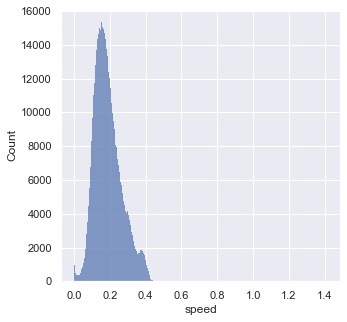

In [26]:
train_data['speed'] = train_data['log_haversine']/train_data['log_trip_duration']
plt.rcParams["figure.figsize"] = (5, 5)
sns.histplot(train_data['speed'])

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

<AxesSubplot:xlabel='speed', ylabel='Count'>

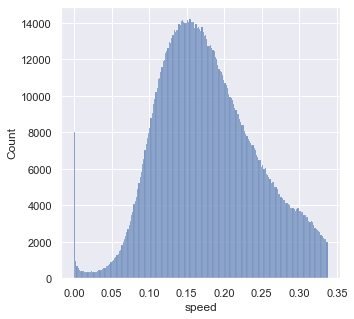

In [27]:
train95 = train_data.copy()
train95 = train95[train95["speed"] < train95["speed"].quantile(0.95)]
plt.rcParams["figure.figsize"] = (5, 5)
sns.histplot(train95["speed"])

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

<AxesSubplot:xlabel='dayofweek', ylabel='hour'>

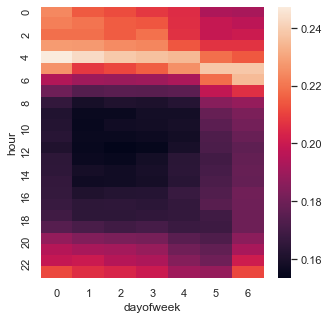

In [28]:
heat = train_data[["hour", "dayofweek", "speed"]].copy()
heat = heat.groupby(["hour", "dayofweek"])["speed"].median().reset_index()
heat = heat.pivot("hour", "dayofweek", "speed")
sns.heatmap(heat)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ**: Потому что в модели уже есть как признаки расстояния, так и времени, что делает данный признак попросту лишним.

In [29]:
train_data.drop('speed', inplace = True, axis = 1)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ**: Минимальна в разгар рабочего дня в будние дни, максимальна в районе 4-5 утра.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [30]:
train_data["load_road"] = (train_data["hour"].between(8, 19) & train_data["dayofweek"].between(0, 4))
train_data["empty_road"] = train_data["hour"].between(0, 6)

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

**Примечание**: Из-за того, что точки меняются с каждым обновлением Кернела, то, какие две точки имелись в виду, остаётся неизвестным, а потому задание выполнить не представляется возможным.

In [31]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [32]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [33]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(["log_trip_duration"], axis=1), train_data["log_trip_duration"], test_size=0.3, random_state=10)
X_train_haversine = pd.DataFrame(X_train, columns = ["load_road", "empty_road", "log_haversine"])

numeric_features = ["log_haversine"]
categorical_features = ["load_road", "empty_road"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_haversine, y_train)
mean_squared_error(model.predict(X_train_haversine), y_train)

0.2543431581010963

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ**: Каждый из них может потенциально иметь корреляцию с длительностью поездки.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [35]:
train_data[["vendor_id", "passenger_count", "store_and_fwd_flag"]].nunique()

vendor_id              2
passenger_count       10
store_and_fwd_flag     2
dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

<AxesSubplot:xlabel='vendor_id', ylabel='log_trip_duration'>

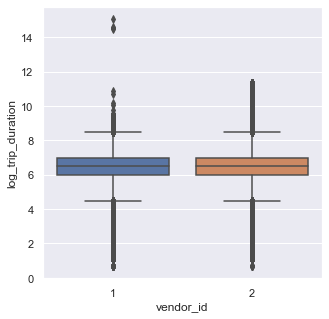

In [36]:
plt.rcParams["figure.figsize"] = (5, 5)
sns.boxplot(data = train_data, x = "vendor_id", y = "log_trip_duration")

<AxesSubplot:xlabel='passenger_count', ylabel='log_trip_duration'>

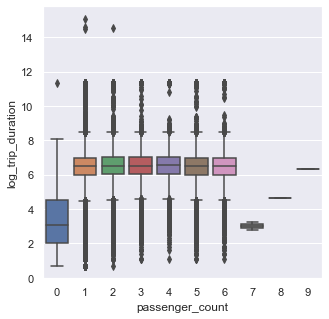

In [37]:
plt.rcParams["figure.figsize"] = (5,5)
sns.boxplot(data = train_data, x = "passenger_count", y = "log_trip_duration")

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='log_trip_duration'>

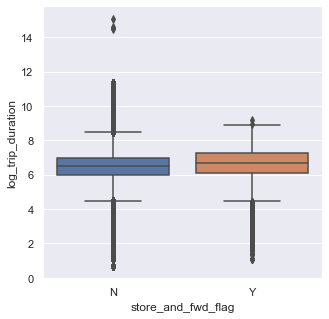

In [38]:
plt.rcParams["figure.figsize"] = (5,5)
sns.boxplot(data = train_data, x = "store_and_fwd_flag", y = "log_trip_duration")

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [39]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
features = ["vendor_id", "store_and_fwd_flag"]
train_data['store_and_fwd_flag'] = 1 * (train_data.store_and_fwd_flag.values == 'Y')
train_data[features] = pd.DataFrame(min_max_scaler.fit_transform(train_data[features])) 

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ**: Вряд ли, слишком много выбросов. Они только скорее испортят модель.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [40]:
X_train_extra = pd.DataFrame(X_train, columns = ["vendor_id", "passenger_count", "store_and_fwd_flag"])

numeric_features = ["passenger_count"]
categorical_features = ["vendor_id", "store_and_fwd_flag"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train_extra, y_train)
mean_squared_error(model.predict(X_train_extra), y_train)

0.6336366553449837

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [41]:
train_data.drop(["vendor_id", "passenger_count", "store_and_fwd_flag"], inplace = True, axis = 1)
X_train.drop(["vendor_id", "passenger_count", "store_and_fwd_flag"], inplace = True, axis = 1)
X_test.drop(["vendor_id", "passenger_count", "store_and_fwd_flag"], inplace = True, axis = 1)